<a href="https://www.kaggle.com/code/siddp6/landscape-generative-adversarial-networks?scriptVersionId=177192204" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Imports

In [1]:
import torch
import os

import torchvision.transforms as T # for modifying the image. 
import matplotlib.pyplot as plt ## for plotting images
import torch.nn as nn ## for convolutional neural network
import torch.nn.functional as F # for loss function

from torch.utils.data import Dataset, DataLoader # for creating dataset and loading them to model.
from PIL import Image # for veiwing the image
from torchvision.utils import make_grid # for making image grid
from tqdm.notebook import tqdm # for progress bar

## Data

In [2]:
data_path = "/kaggle/input/intel-image-classification/seg_train/seg_train/mountain"

- Neural networks generally perform better with input data that ranges around 0 and has a small, uniform scale. 
- By normalizing the images, the pixel values (originally ranging from 0 to 255) are typically scaled to a range such as -1 to 1 (if using a mean of 0.5 and standard deviation of 0.5). 
- This helps in speeding up the convergence during training because it ensures that the input features (pixel values) are on a similar scale, aiding the optimization algorithms to work more efficiently.


In [3]:
# Define the size of the images, higher value means higher quality
image_size = 256

"""
The stats tuple (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), represents the means and standard deviations for each 
of the three color channels (red, green, blue) used to normalize the images. 
"""

stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

# Define the batch size for data loading
batch_size = 128

# Define the transformations to be applied to the images
transformer = T.Compose([
    T.Resize(image_size),               # Resize the image to the specified size
    T.CenterCrop(image_size),           # Crop the center of the image to the specified size
    T.RandomHorizontalFlip(0.5),        # Randomly flip the image horizontally with a probability of 0.5
    T.ToTensor(),                       # Convert the image to a PyTorch tensor
    T.Normalize(*stats)                 # Normalize the tensor using the specified mean and std deviation
])

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Initializes the dataset object.
        
        Args:
            root_dir (str): Directory containing the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir  # Path to the directory where images are stored
        self.transform = transform  # Transformations to be applied to the images
        # List all images in root_dir that end with png, jpg, or jpeg
        self.images = [os.path.join(root_dir, img) for img in os.listdir(root_dir) if img.endswith(('png', 'jpg', 'jpeg'))]

    def __len__(self):
        """
        Returns the total number of images in the dataset.
        """
        return len(self.images)

    def __getitem__(self, idx):
        """
        Retrieves an image from the dataset at the specified index.

        Args:
            idx (int): Index of the image to retrieve.
        
        Returns:
            image (PIL.Image): The image at the specified index after applying transformations.
        """
        img_path = self.images[idx]  # Get the image path
        image = Image.open(img_path).convert('RGB')  # Open the image and convert it to RGB
        if self.transform:
            image = self.transform(image)  # Apply transformations, if any
        return image

In [5]:
# Create an instance of CustomImageDataset with specified path and transformations
dataset = CustomImageDataset(data_path, transform=transformer)
# DataLoader to handle batching and loading of the dataset
dataset_loader = DataLoader(
    dataset,                 # The dataset to load
    batch_size,              # Number of images in each batch
    shuffle=True,            # Shuffle the data to randomize the order of images
    num_workers=3,           # Number of subprocesses to use for data loading
    pin_memory=True          # If True, the DataLoader will copy tensors into CUDA pinned memory before returning them
)

- The pin_memory option in PyTorch's DataLoader is used to enable faster transfers of data from host (CPU) memory to GPU memory, which can lead to performance improvements during training deep learning models.

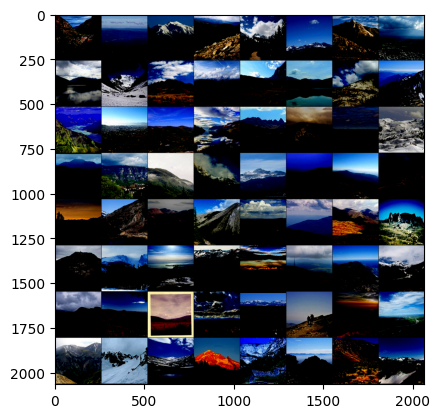

In [6]:
def show_images(images, nmax=64):
    plt.imshow(make_grid(images[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl):
    for images in dl:
        show_images(images)
        break
        
show_batch(dataset_loader)

## Discriminator and Generator

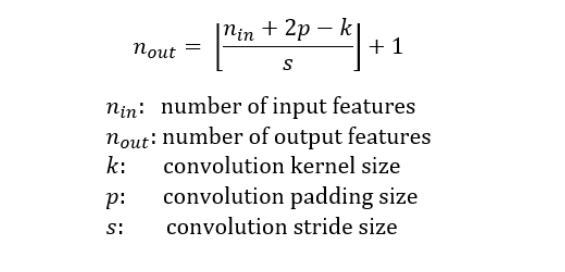

In [7]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    # Input: 256x256, Output: (256 - 4 + 2*1) / 2 + 1 = 128x128
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    # Input: 128x128, Output: (128 - 4 + 2*1) / 2 + 1 = 64x64
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    # Input: 64x64, Output: (64 - 4 + 2*1) / 2 + 1 = 32x32
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    # Input: 32x32, Output: (32 - 4 + 2*1) / 2 + 1 = 16x16
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
    # Input: 16x16, Output: (16 - 4 + 2*1) / 2 + 1 = 8x8
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
    # Input: 8x8, Output: (8 - 4 + 2*1) / 2 + 1 = 4x4
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # Input: 4x4, Output: (4 - 4 + 0*0) / 1 + 1 = 1x1

    nn.Flatten(),
    nn.Sigmoid()
)

In [8]:
latent_size = 512

generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    # Input: 1x1, Output: (1 - 1)*1 - 2*0 + 4 = 4x4
    nn.BatchNorm2d(1024),
    nn.ReLU(True),

    nn.ConvTranspose2d(1024, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    # Input: 4x4, Output: (4 - 1)*2 - 2*1 + 4 = 8x8
    nn.BatchNorm2d(1024),
    nn.ReLU(True),

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    # Input: 8x8, Output: (8 - 1)*2 - 2*1 + 4 = 16x16
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    # Input: 16x16, Output: (16 - 1)*2 - 2*1 + 4 = 32x32
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    # Input: 32x32, Output: (32 - 1)*2 - 2*1 + 4 = 64x64
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    # Input: 64x64, Output: (64 - 1)*2 - 2*1 + 4 = 128x128
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    # Input: 128x128, Output: (128 - 1)*2 - 2*1 + 4 = 256x256
    nn.BatchNorm2d(32),
    nn.ReLU(True),

    nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1, bias=False),
    # Input: 256x256, Output: (256 - 1)*1 - 2*1 + 3 = 256x256
    nn.Tanh()  # Normalize output to [-1, 1]
)

## Set GPU

In [9]:
def get_device():
    """
    Determines the best available device for computations (CPU or GPU).
    
    Returns:
        torch.device: The device ('cuda' or 'cpu') where tensors should be allocated.
    """
    if torch.cuda.is_available():
        return torch.device('cuda')  # Return a GPU device if CUDA is available
    else:
        return torch.device('cpu')   # Return CPU if CUDA is not available

def to_device(data, device):
    """
    Recursively moves tensors to the specified device.
    
    Args:
        data (tensor, list, tuple): Data to be moved to the device.
        device (torch.device): The device to move data to.
        
    Returns:
        Tensor or list of tensors moved to the specified device.
    """
    if isinstance(data, (list, tuple)):
        # Recursively move each item to the device if data is a list or tuple
        return [to_device(x, device) for x in data]
    else:
        # Move tensor to device asynchronously for performance
        return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """
    A wrapper around DataLoader to automatically move data to a device during iteration.
    """
    def __init__(self, dl, device):
        """
        Initializes the DeviceDataLoader.
        
        Args:
            dl (DataLoader): The DataLoader whose batches will be moved to the device.
            device (torch.device): The device to move data to.
        """
        self.dl = dl      # The DataLoader to wrap
        self.device = device  # The device to move data to

    def __iter__(self):
        """
        Yield a batch of data after moving it to the specified device.
        """
        for data in self.dl:
            yield to_device(data, self.device)  # Move each batch to device before yielding

    def __len__(self):
        """
        Returns the number of batches available in the DataLoader.
        """
        return len(self.dl)  # Return the length of the underlying DataLoader

In [10]:
device = get_device()

dataset_loader = DeviceDataLoader(dataset_loader, device)
print(f"Train loader device: {next(iter(dataset_loader))[0].device}")

discriminator = to_device(discriminator, device)
print(f"Discriminator device: {next(discriminator.parameters()).device}")

generator = to_device(generator, device)
print(f"Generator device: {next(generator.parameters()).device}")

Train loader device: cuda:0
Discriminator device: cuda:0
Generator device: cuda:0


## Training

torch.Size([128, 512, 1, 1])
torch.Size([128, 3, 256, 256])


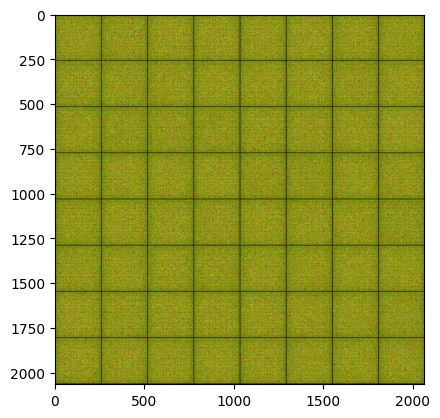

In [11]:
xb = torch.randn(batch_size, 512, 1, 1) # random latent tensors
xb = to_device(xb, device)
fake_images = generator(xb)
print(xb.shape)
print(fake_images.shape)
fake_images_cpu = fake_images.cpu()  # Move the tensor to CPU
show_images(fake_images_cpu)

In [12]:
def train_discriminator(real_images, opt_d):
    """
    Trains the discriminator network with both real and fake images.
    
    Args:
        real_images (torch.Tensor): A batch of real images.
        opt_d (torch.optim.Optimizer): The optimizer for the discriminator.
    
    Returns:
        tuple: Contains the total loss, mean probability score assigned to real images, 
               and mean probability score assigned to fake images.
    """
    # Clear previous gradients; important for correct gradient accumulation
    opt_d.zero_grad()

    # Forward pass real images through the discriminator to compute the loss on real images
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)  # Targets for real images
    real_loss = F.binary_cross_entropy(real_preds, real_targets)  # Compute BCE loss
    real_score = torch.mean(real_preds).item()  # Calculate the mean of the discriminator outputs for real images

    # Generate fake images from noise
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)  # Sample random latent vector
    fake_images = generator(latent)  # Generate fake images using the generator

    # Forward pass fake images through the discriminator to compute the loss on fake images
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)  # Targets for fake images
    fake_preds = discriminator(fake_images)  # Discriminator predictions for fake images
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)  # Compute BCE loss
    fake_score = torch.mean(fake_preds).item()  # Calculate the mean of the discriminator outputs for fake images

    # Combine losses and perform a backward pass to update the discriminator
    loss = real_loss + fake_loss  # Total loss for the discriminator
    loss.backward()  # Backpropagation
    opt_d.step()  # Update discriminator weights

    return loss.item(), real_score, fake_score  # Return the total loss and discriminator scores for real and fake images


In [13]:
def train_generator(opt_g):
    """
    Trains the generator network to improve its ability to generate realistic images.
    
    Args:
        opt_g (torch.optim.Optimizer): The optimizer for the generator.
    
    Returns:
        float: The loss value indicating how well the generator is fooling the discriminator.
    """
    # Clear previous gradients from the optimizer, necessary for correct gradient computation
    opt_g.zero_grad()

    # Generate a batch of fake images using random noise as input
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)  # Random noise vector
    fake_images = generator(latent)  # Generate fake images from noise

    # Forward pass fake images through the discriminator
    preds = discriminator(fake_images)  # Discriminator's predictions on the fake images
    targets = torch.ones(batch_size, 1, device=device)  # Set targets as 1, representing 'real'
    loss = F.binary_cross_entropy(preds, targets)  # Compute loss to fool the discriminator

    # Perform a backward pass to compute gradients
    loss.backward()  # Backpropagate to compute gradients
    opt_g.step()  # Update generator weights based on gradients

    return loss.item()  # Return the computed loss value

In [14]:
fixed_latent = torch.randn(128, latent_size, 1, 1, device=device)

In [15]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [16]:
def fit(epochs, lr, start_idx=1):
    """
    Trains both the generator and discriminator networks over a specified number of epochs.
    
    Args:
        epochs (int): Total number of epochs to train.
        lr (float): Learning rate for the optimizers.
        start_idx (int): Starting index for saving generated samples.
    
    Returns:
        tuple: Lists containing the losses for the generator and discriminator, and scores for real and fake images.
    """
    torch.cuda.empty_cache()  # Clear GPU cache to free up unused memory and avoid CUDA errors

    # Initialize lists to store losses and scores for analysis
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Setup the optimizers for both networks with Adam optimizer
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    # Loop over the dataset for a given number of epochs
    for epoch in range(epochs):
        for real_images in tqdm(dataset_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            # Train the discriminator on real and generated fake images
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train the generator to improve at fooling the discriminator
            loss_g = train_generator(opt_g)

        # Save the losses and scores for this epoch
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Output the training progress
        print(f"Epoch [{epoch+1}/{epochs}], loss_g: {loss_g:.4f}, loss_d: {loss_d:.4f}, real_score: {real_score:.4f}, fake_score: {fake_score:.4f}")

        # Save generated images every 10 epochs and at the last epoch
        if epoch % 10 == 0 or epoch == epochs - 1:
            save_samples(epoch + start_idx, fixed_latent, show=False)  # Save sample images

    return losses_g, losses_d, real_scores, fake_scores

Epoch 1/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 3.6984, loss_d: 0.7812, real_score: 0.8595, fake_score: 0.3004


Epoch 2/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 2.9476, loss_d: 0.3273, real_score: 0.8689, fake_score: 0.0614


Epoch 3/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 0.2370, loss_d: 2.0733, real_score: 0.3059, fake_score: 0.2053


Epoch 4/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 5.1528, loss_d: 0.6341, real_score: 0.9489, fake_score: 0.3928


Epoch 5/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 3.2179, loss_d: 2.9908, real_score: 0.1456, fake_score: 0.0057


Epoch 6/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 5.2329, loss_d: 1.4627, real_score: 0.9316, fake_score: 0.6434


Epoch 7/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 8.1713, loss_d: 2.8919, real_score: 0.9541, fake_score: 0.8995


Epoch 8/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 0.6220, loss_d: 1.2947, real_score: 0.3600, fake_score: 0.1258


Epoch 9/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 4.9817, loss_d: 0.2861, real_score: 0.9195, fake_score: 0.1661


Epoch 10/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 3.4298, loss_d: 0.6357, real_score: 0.7129, fake_score: 0.2129


Epoch 11/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 2.2925, loss_d: 1.0783, real_score: 0.5082, fake_score: 0.1255


Epoch 12/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 8.0155, loss_d: 2.6295, real_score: 0.9298, fake_score: 0.8928


Epoch 13/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 4.3119, loss_d: 1.7632, real_score: 0.4828, fake_score: 0.5118


Epoch 14/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 1.8875, loss_d: 1.0744, real_score: 0.5716, fake_score: 0.3297


Epoch 15/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 1.6736, loss_d: 0.8558, real_score: 0.6431, fake_score: 0.3003


Epoch 16/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 0.9455, loss_d: 1.6116, real_score: 0.3009, fake_score: 0.2140


Epoch 17/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 2.0493, loss_d: 0.9714, real_score: 0.6194, fake_score: 0.3446


Epoch 18/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 1.6258, loss_d: 2.1096, real_score: 0.1627, fake_score: 0.0348


Epoch 19/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 0.8828, loss_d: 1.4517, real_score: 0.4702, fake_score: 0.3442


Epoch 20/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 1.5362, loss_d: 1.2256, real_score: 0.5180, fake_score: 0.3935


Epoch 21/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 1.4000, loss_d: 1.2574, real_score: 0.7035, fake_score: 0.4756


Epoch 22/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 1.6659, loss_d: 1.3668, real_score: 0.7007, fake_score: 0.5852


Epoch 23/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 1.8322, loss_d: 0.6946, real_score: 0.7424, fake_score: 0.3012


Epoch 24/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 1.3030, loss_d: 1.0055, real_score: 0.7670, fake_score: 0.4649


Epoch 25/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 3.1922, loss_d: 0.8218, real_score: 0.7382, fake_score: 0.3497


Epoch 26/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 2.0615, loss_d: 2.2147, real_score: 0.7246, fake_score: 0.7034


Epoch 27/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 0.4170, loss_d: 2.6361, real_score: 0.1304, fake_score: 0.0557


Epoch 28/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 0.8288, loss_d: 1.2453, real_score: 0.4115, fake_score: 0.2424


Epoch 29/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 2.4282, loss_d: 0.5009, real_score: 0.7998, fake_score: 0.2047


Epoch 30/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 1.6523, loss_d: 0.8834, real_score: 0.5894, fake_score: 0.2545


Epoch 31/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 1.5587, loss_d: 0.8170, real_score: 0.6660, fake_score: 0.2996


Epoch 32/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 1.1520, loss_d: 1.0389, real_score: 0.5862, fake_score: 0.3495


Epoch 33/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 1.6808, loss_d: 1.1108, real_score: 0.6205, fake_score: 0.3687


Epoch 34/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 2.0231, loss_d: 1.1585, real_score: 0.6099, fake_score: 0.4197


Epoch 35/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 0.8308, loss_d: 2.0462, real_score: 0.4418, fake_score: 0.6334


Epoch 36/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 1.7480, loss_d: 1.0723, real_score: 0.6765, fake_score: 0.4126


Epoch 37/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 2.6362, loss_d: 1.1153, real_score: 0.7323, fake_score: 0.4808


Epoch 38/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 2.1600, loss_d: 0.7951, real_score: 0.6813, fake_score: 0.2685


Epoch 39/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 1.3219, loss_d: 1.5322, real_score: 0.7236, fake_score: 0.6463


Epoch 40/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 3.3298, loss_d: 1.2997, real_score: 0.7047, fake_score: 0.5580


Epoch 41/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 0.7985, loss_d: 1.2982, real_score: 0.3940, fake_score: 0.2077


Epoch 42/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 2.6912, loss_d: 1.0948, real_score: 0.8121, fake_score: 0.5435


Epoch 43/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 6.7594, loss_d: 1.8958, real_score: 0.9070, fake_score: 0.7947


Epoch 44/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 2.9457, loss_d: 0.9196, real_score: 0.6814, fake_score: 0.3314


Epoch 45/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 1.6657, loss_d: 1.0612, real_score: 0.8197, fake_score: 0.5534


Epoch 46/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 2.2596, loss_d: 1.6892, real_score: 0.2307, fake_score: 0.0598


Epoch 47/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 1.6670, loss_d: 0.8698, real_score: 0.5276, fake_score: 0.1636


Epoch 48/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 3.9852, loss_d: 0.2881, real_score: 0.9422, fake_score: 0.1985


Epoch 49/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 0.7433, loss_d: 1.0428, real_score: 0.7445, fake_score: 0.4721


Epoch 50/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 1.3731, loss_d: 2.1110, real_score: 0.1577, fake_score: 0.0524


Epoch 51/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 1.8690, loss_d: 1.1632, real_score: 0.7689, fake_score: 0.5680


Epoch 52/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 1.5580, loss_d: 1.1400, real_score: 0.6361, fake_score: 0.4483


Epoch 53/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 0.4604, loss_d: 1.2801, real_score: 0.3800, fake_score: 0.1782


Epoch 54/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 1.8013, loss_d: 0.3440, real_score: 0.8378, fake_score: 0.1326


Epoch 55/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 1.5577, loss_d: 0.9152, real_score: 0.5725, fake_score: 0.2046


Epoch 56/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 1.6945, loss_d: 1.1076, real_score: 0.6738, fake_score: 0.4342


Epoch 57/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 0.8131, loss_d: 1.6936, real_score: 0.2563, fake_score: 0.1317


Epoch 58/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 1.9411, loss_d: 1.0702, real_score: 0.5881, fake_score: 0.2972


Epoch 59/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 4.5387, loss_d: 1.2565, real_score: 0.5642, fake_score: 0.4125


Epoch 60/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 7.1317, loss_d: 1.6316, real_score: 0.8587, fake_score: 0.7369


Epoch 61/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 3.0803, loss_d: 0.7871, real_score: 0.6536, fake_score: 0.2411


Epoch 62/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 2.7150, loss_d: 0.3611, real_score: 0.8296, fake_score: 0.1148


Epoch 63/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 3.6490, loss_d: 0.3472, real_score: 0.7931, fake_score: 0.0651


Epoch 64/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 4.4400, loss_d: 1.2188, real_score: 0.9431, fake_score: 0.6043


Epoch 65/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 3.0583, loss_d: 0.5291, real_score: 0.6975, fake_score: 0.1285


Epoch 66/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 5.1695, loss_d: 0.1670, real_score: 0.9779, fake_score: 0.1267


Epoch 67/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 4.5003, loss_d: 9.4544, real_score: 0.0020, fake_score: 0.0000


Epoch 68/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 4.2488, loss_d: 0.2989, real_score: 0.9233, fake_score: 0.1878


Epoch 69/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 3.4470, loss_d: 0.2083, real_score: 0.9642, fake_score: 0.1507


Epoch 70/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 5.3705, loss_d: 0.1860, real_score: 0.9577, fake_score: 0.1277


Epoch 71/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 1.6013, loss_d: 1.1565, real_score: 0.5832, fake_score: 0.4026


Epoch 72/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 4.4867, loss_d: 1.2062, real_score: 0.9631, fake_score: 0.6366


Epoch 73/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 2.6966, loss_d: 0.6731, real_score: 0.5877, fake_score: 0.0751


Epoch 74/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 3.7883, loss_d: 0.3395, real_score: 0.8362, fake_score: 0.1211


Epoch 75/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 2.4598, loss_d: 1.6161, real_score: 0.6669, fake_score: 0.4926


Epoch 76/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 1.8607, loss_d: 1.6134, real_score: 0.2432, fake_score: 0.0774


Epoch 77/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 4.0640, loss_d: 0.2699, real_score: 0.9038, fake_score: 0.1475


Epoch 78/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 3.0005, loss_d: 0.4368, real_score: 0.7502, fake_score: 0.1181


Epoch 79/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 3.4682, loss_d: 0.5888, real_score: 0.9540, fake_score: 0.3882


Epoch 80/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 0.7514, loss_d: 1.7324, real_score: 0.4088, fake_score: 0.3527


Epoch 81/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 0.6682, loss_d: 2.0194, real_score: 0.3031, fake_score: 0.3177


Epoch 82/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 1.0525, loss_d: 2.1201, real_score: 0.2145, fake_score: 0.0697


Epoch 83/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 1.9011, loss_d: 1.4750, real_score: 0.3498, fake_score: 0.2510


Epoch 84/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 2.4655, loss_d: 1.4866, real_score: 0.4518, fake_score: 0.4017


Epoch 85/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 3.2466, loss_d: 0.6823, real_score: 0.8437, fake_score: 0.3646


Epoch 86/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 2.4887, loss_d: 0.8027, real_score: 0.6802, fake_score: 0.3099


Epoch 87/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 2.9075, loss_d: 1.5508, real_score: 0.9443, fake_score: 0.7307


Epoch 88/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 2.1874, loss_d: 1.3914, real_score: 0.8597, fake_score: 0.6691


Epoch 89/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 0.9318, loss_d: 1.5686, real_score: 0.2857, fake_score: 0.0830


Epoch 90/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 0.5704, loss_d: 1.8741, real_score: 0.2637, fake_score: 0.2566


Epoch 91/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 2.8086, loss_d: 0.8171, real_score: 0.6857, fake_score: 0.2876


Epoch 92/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 1.8609, loss_d: 1.2220, real_score: 0.6988, fake_score: 0.5539


Epoch 93/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 1.5293, loss_d: 0.8602, real_score: 0.6082, fake_score: 0.2679


Epoch 94/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 1.3480, loss_d: 1.3270, real_score: 0.4108, fake_score: 0.2675


Epoch 95/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 4.0794, loss_d: 1.0068, real_score: 0.7639, fake_score: 0.4727


Epoch 96/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 1.2004, loss_d: 1.2449, real_score: 0.4053, fake_score: 0.1664


Epoch 97/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 1.2743, loss_d: 1.0269, real_score: 0.7013, fake_score: 0.4309


Epoch 98/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 2.1805, loss_d: 0.5472, real_score: 0.6340, fake_score: 0.0378


Epoch 99/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 1.2904, loss_d: 0.4734, real_score: 0.7702, fake_score: 0.1695


Epoch 100/100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 3.2954, loss_d: 0.5255, real_score: 0.7842, fake_score: 0.1778


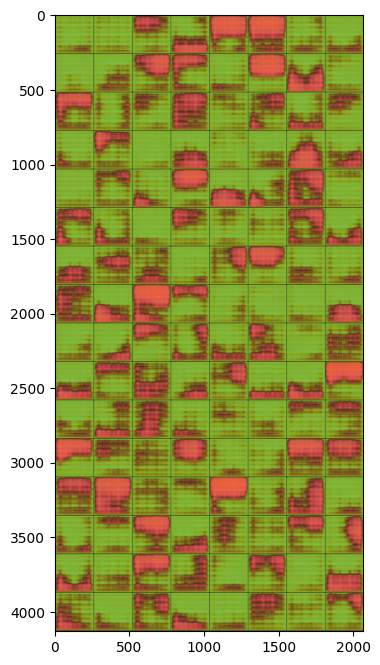

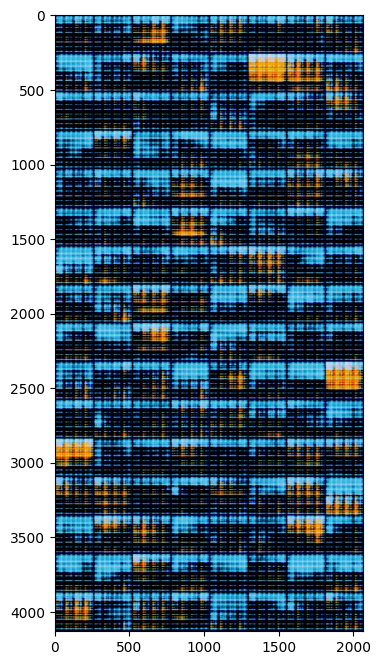

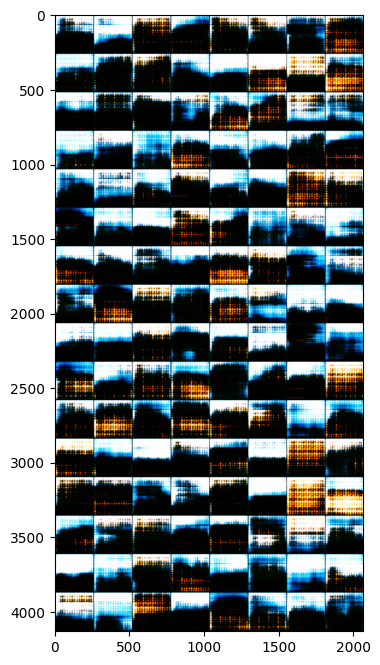

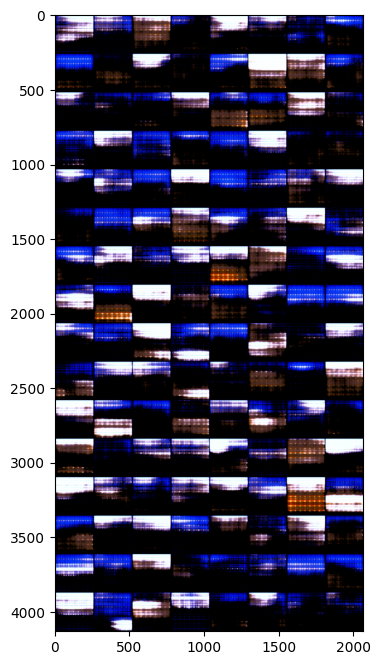

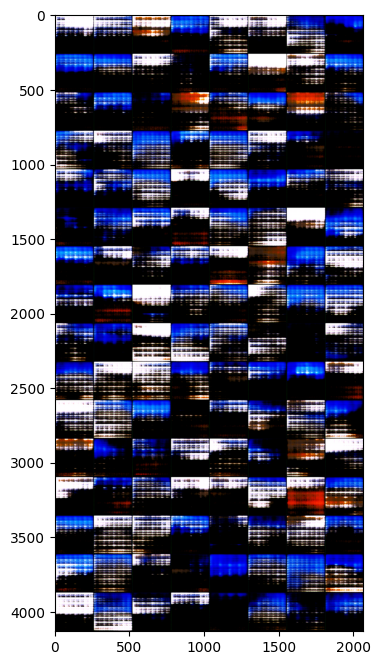

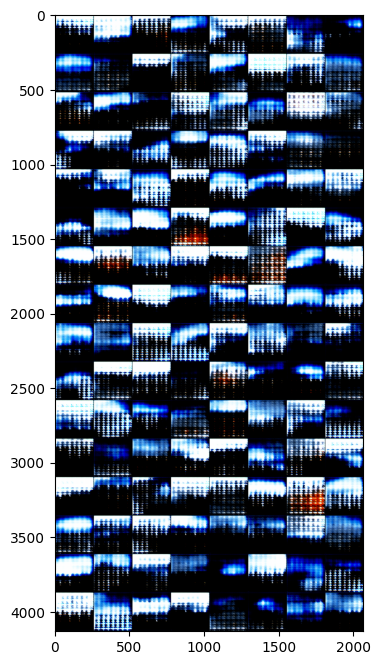

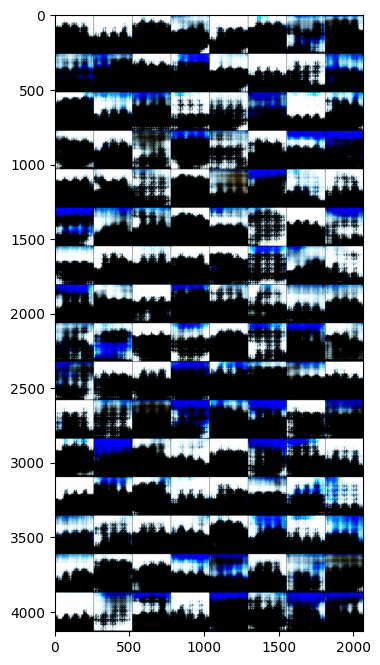

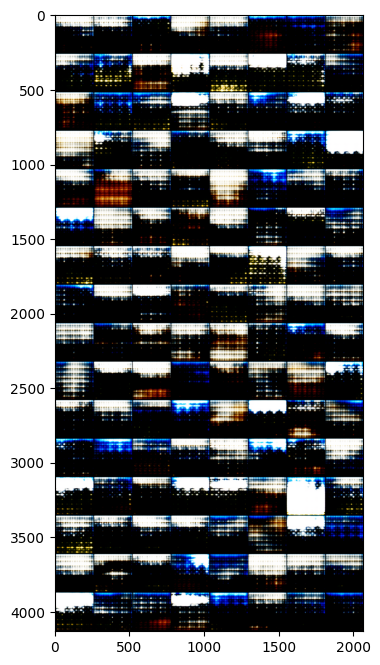

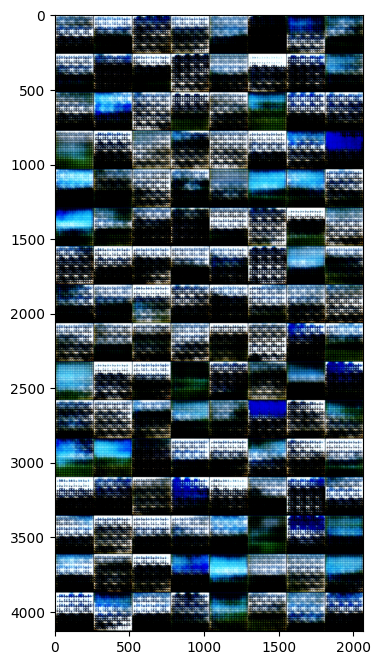

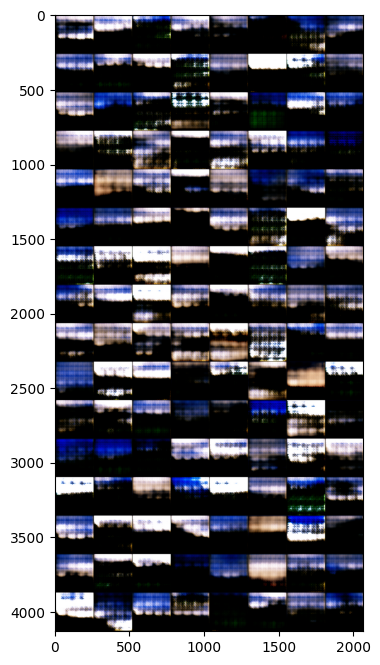

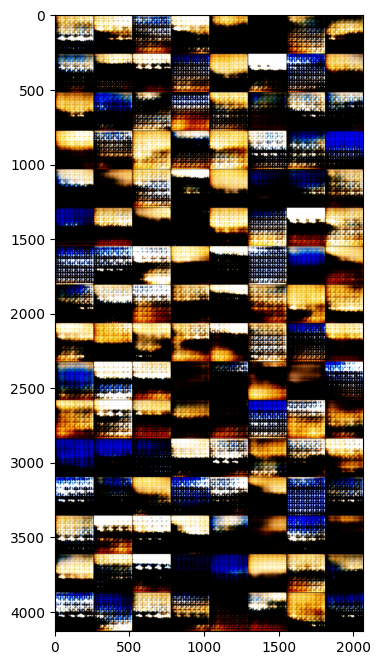

In [17]:
lr = 0.002
epochs = 100
history = fit(epochs, lr)